<img src="https://warehouseblueprint.com/wp-content/uploads/2018/01/quora-2.png" width="500">

#  1. BUSINESS PROBLEM
## 1.1 Description
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>

## 1.2 Problem Statement
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

## 1.3 Real world/Business Objectives and Constraints
1. The cost of a mis-classification can be very high.
2. We would want a probability of a pair of questions to be duplicates so that we can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# 2. MACHINE LEARNING PROBLEM
## 2.1 Data
### 2.1.1 Data Overview
<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

###  2.1.2 Example Data point

<img src="https://meiyipan.com/images/train.png" height="1200" width="800">

## 2.2 Mapping the real world problem to an ML problem  
### 2.2.1 Type of Machine Leaning Problem
<p> It is a <b>binary classification</b> problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

### 2.2.2 Performance Metric
* log-loss
* Binary Confusion Matrix

# 3. EXPLORATORY DATA ANALYSIS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
from collections import Counter
import time
import joblib
from datetime import datetime as dt
from tqdm import tqdm


import sqlite3
from sqlalchemy import create_engine

import nltk
import re
import math
import distance
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from gensim.models import Word2Vec
from gensim.models import KeyedVectors 

import scipy.stats as st
from scipy.sparse import hstack,vstack
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

## 3.1 Reading data

In [43]:
quora_df = pd.read_csv("train.csv")
print("Number of data points :",quora_df.shape[0])
print("Number of dimenions :",quora_df.shape[1])

Number of data points : 404290
Number of dimenions : 6


In [44]:
quora_df.head(10)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   
8   8    17    18                    When do you use シ instead of し?   
9   9    19    20  Motorola (company): Can I hack my Charter Moto...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1  
6  What keeps childern active and far from phone ...             0  
7          What should I do to be a great geologist?             1  
8              When do you use "&" instead of "and"?             0  
9  How do I hack Motorola DCX3400 for free internet?             0

In [18]:
quora_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<b>Observations</b>
- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

## 3.2 Basic stats

### 3.2.1 Distribution of data points among output classes
- Number of duplicate(similar) and non-duplicate(non similar) questions

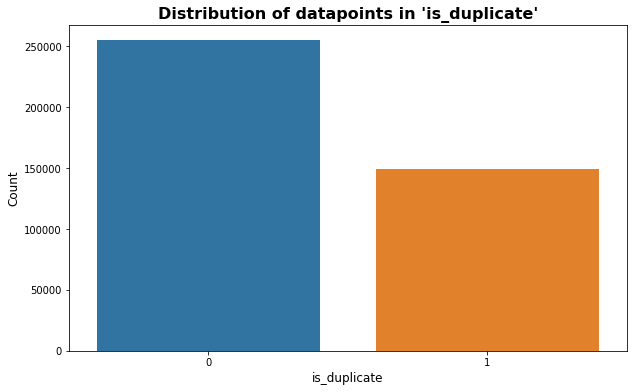

In [19]:
dist_dup = quora_df.groupby('is_duplicate',as_index = False)['id'].count()

plt.figure(figsize = (10,6))
sns.barplot(x = 'is_duplicate', y = 'id', data = dist_dup)
plt.title("Distribution of datapoints in 'is_duplicate'",fontsize = 16,fontweight= 'bold')
plt.xlabel("is_duplicate",fontsize = 12)
plt.ylabel("Count",fontsize = 12)
plt.grid(False)
plt.show()

In [20]:
print(quora_df['is_duplicate'].value_counts())

print('\nPercentage of Question pairs that are not Similar (is_duplicate = 0): {}%'.format(100 - round(quora_df['is_duplicate'].mean()*100, 2)))
print('\nPercentage of Question pairs that are Similar (is_duplicate = 1): {}%'.format(round(quora_df['is_duplicate'].mean()*100, 2)))

0    255027
1    149263
Name: is_duplicate, dtype: int64

Percentage of Question pairs that are not Similar (is_duplicate = 0): 63.08%

Percentage of Question pairs that are Similar (is_duplicate = 1): 36.92%


### 3.2.2 Number of unique questions

In [21]:
qids= pd.Series(quora_df['qid1'].tolist() + quora_df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print("Total number of unique questions: ",unique_qs)
print("\nNumber of unique questions that appeared more than one time : {}({} %)".format(qs_morethan_onetime,qs_morethan_onetime*100/unique_qs))
print("\nMaximum number of times a single question is repeated : ",max(qids.value_counts()))

Total number of unique questions:  537933

Number of unique questions that appeared more than one time : 111780(20.77953945937505 %)

Maximum number of times a single question is repeated :  157


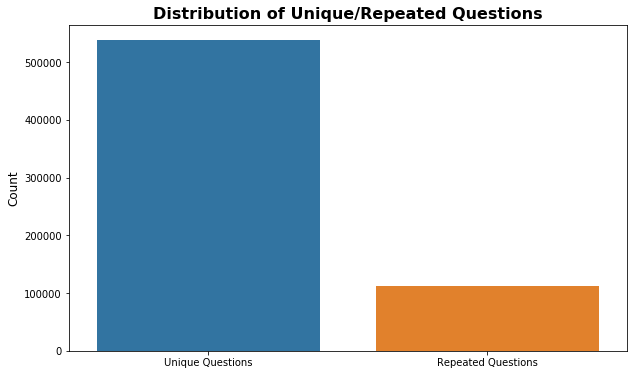

In [22]:
x = ["Unique Questions", "Repeated Questions"]
y = [unique_qs, qs_morethan_onetime]

plt.figure(figsize = (10,6))
sns.barplot(x,y)
plt.title("Distribution of Unique/Repeated Questions",fontsize = 16,fontweight= 'bold')
plt.ylabel("Count",fontsize = 12)
plt.grid(False)
plt.show()

### 3.2.3 Checking for Duplicates

In [23]:
qs_pair_duplicates = quora_df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate Question pairs :",quora_df.shape[0] - qs_pair_duplicates.shape[0])

Number of duplicate Question pairs : 0


### 3.2.4 Checking for NULL values

In [25]:
null_rows = quora_df[quora_df.isnull().any(1)]
null_rows

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

<b>Observations</b>
-  There were two rows with null values in question2  and one row with null values in question1.

In [26]:
# Filling the null values with ' '
quora_df = quora_df.fillna('')
null_rows = quora_df[quora_df.isnull().any(1)]
print("Data points with missing values :",null_rows.shape[0])

Data points with missing values : 0


### 3.2.5 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



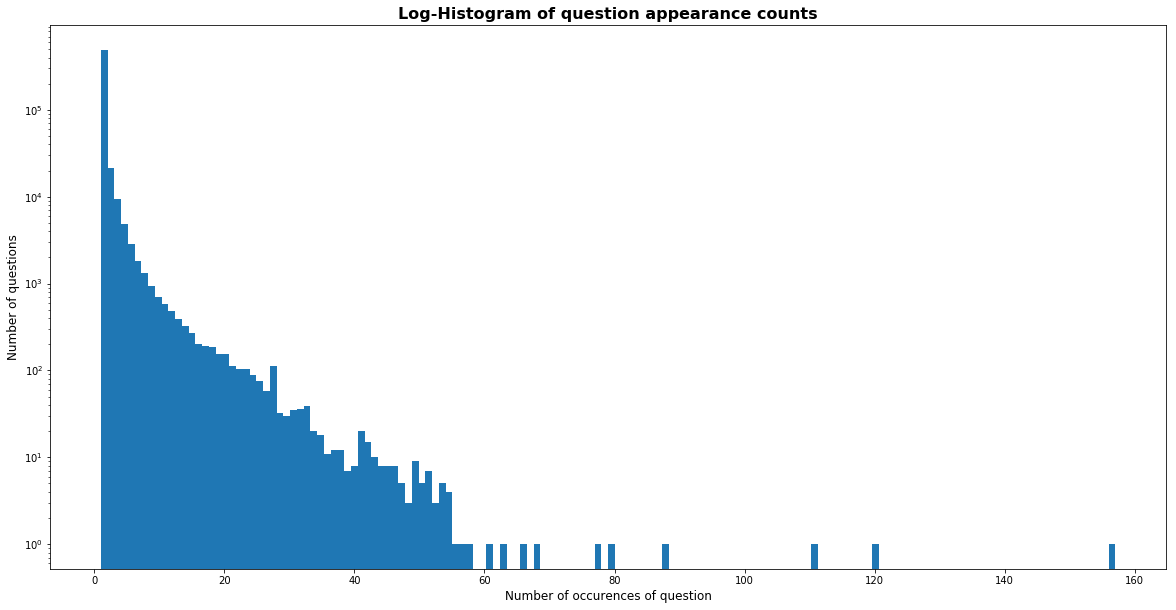

In [28]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=150)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts',fontsize = 16,fontweight = 'bold')

plt.xlabel('Number of occurences of question',fontsize = 12)

plt.ylabel('Number of questions',fontsize = 12)

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<b>Observations</b>
-  Maximum number of times a single question is repeated: 157
-  Distribution of Number of occurrences of each question follows a log-normal distribution.

## 3.3 Basic Feature Extraction (before cleaning)

Let us now construct some basic features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of Question 1
 - ____q2len____ = Length of Question 2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ = (Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [29]:
if os.path.isfile("quora_basicfeatures_without_preprocessing_train.csv"):
    print("Let's start with the Quora Question Pairs Case Study. ")

else:
    start = dt.now()
    
    quora_df['freq_qid1'] = quora_df.groupby('qid1')['qid1'].transform('count')
    quora_df['freq_qid2'] = quora_df.groupby('qid2')['qid2'].transform('count')
    quora_df['q1len'] = quora_df['question1'].str.len()
    quora_df['q2len'] = quora_df['question2'].str.len()
    quora_df['q1_n_words'] = quora_df['question1'].apply(lambda x: len(x.split(" ")))
    quora_df['q2_n_words'] = quora_df['question2'].apply(lambda x: len(x.split(" ")))
    
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    quora_df['word_Common'] = quora_df.apply(normalized_word_Common,axis =1)
    
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    quora_df['word_Total'] = quora_df.apply(normalized_word_Total,axis =1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1 & w2)/(len(w1) + len(w2)))
    quora_df['word_share'] = quora_df.apply(normalized_word_share,axis =1)
    
    quora_df['freq_q1+freq_q2'] = quora_df['freq_qid1'] + quora_df['freq_qid2']
    quora_df['freq_q1-freq_q2'] = abs(quora_df['freq_qid1'] - quora_df['freq_qid2'])
    
    quora_df.to_csv("quora_basicfeatures_without_preprocessing_train.csv",index = False)
    
    print("Time taken to run this cell: ",dt.now() - start)
    
quora_df.head()

Time taken to run this cell:  0:01:17.922406


id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+freq_q2  freq_q1-freq_q2  
0    0.434783                2                0  
1    0.200000                5                3  
2    0.166667                2                0  
3    0.000000                2                0  
4    0.100000                4                2

### 3.3.1 Analysis of some of the basic extracted features

In [30]:
print ("Minimum length of the questions in Question 1 : " , min(quora_df['q1_n_words']))
print ("Minimum length of the questions in Question 2 : " , min(quora_df['q2_n_words']))

print ("Number of Questions with minimum length [Question1] :", quora_df[quora_df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [Question2] :", quora_df[quora_df['q2_n_words']== 1].shape[0])

print ("\nMaximum length of the questions in Question 1 : " , max(quora_df['q1_n_words']))
print ("Maximum length of the questions in Question 2 : " , max(quora_df['q2_n_words']))

print ("\nAverage length of the questions in Question 1 : " , np.mean(quora_df['q1_n_words']))
print ("Average length of the questions in Question 2 : " , np.mean(quora_df['q2_n_words']))

Minimum length of the questions in Question 1 :  1
Minimum length of the questions in Question 2 :  1
Number of Questions with minimum length [Question1] : 67
Number of Questions with minimum length [Question2] : 24

Maximum length of the questions in Question 1 :  125
Maximum length of the questions in Question 2 :  237

Average length of the questions in Question 1 :  10.94459175344431
Average length of the questions in Question 2 :  11.185119592371812


#### 3.3.1.1 EDA on Feature: word_share

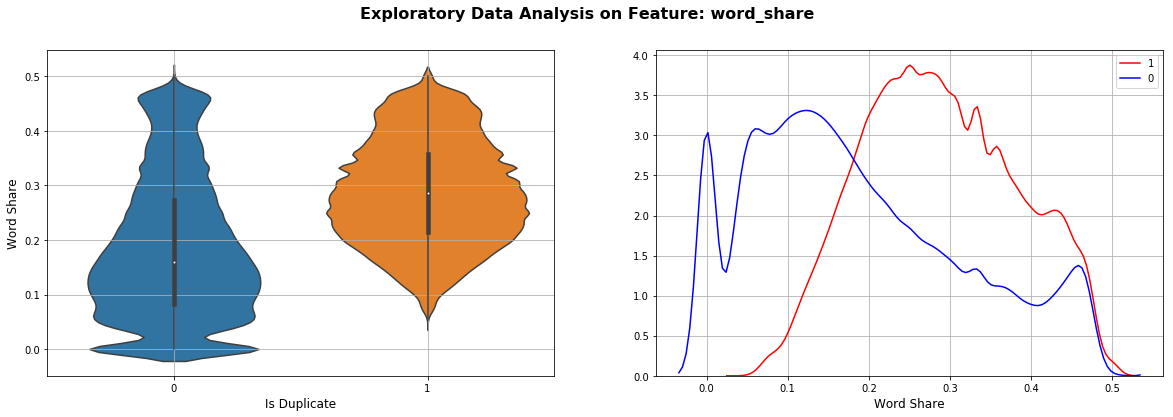

In [31]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_share", data = quora_df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Word Share",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(quora_df[quora_df['is_duplicate'] == 1.0]['word_share'], label = "1", color = "red", hist=False)
sns.distplot(quora_df[quora_df['is_duplicate'] == 0.0]['word_share'], label = "0", color = "blue", hist=False)
plt.xlabel("Word Share",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: word_share",fontsize=16,fontweight="bold")
plt.show()

<b>Observations</b>
- From violin plot,the average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)
- From pdf plot, te distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.
- word_share can be considered as one of the important feature for detecting duplicate/non duplicate questions.

#### 3.3.1.2 EDA on Feature: word_Common

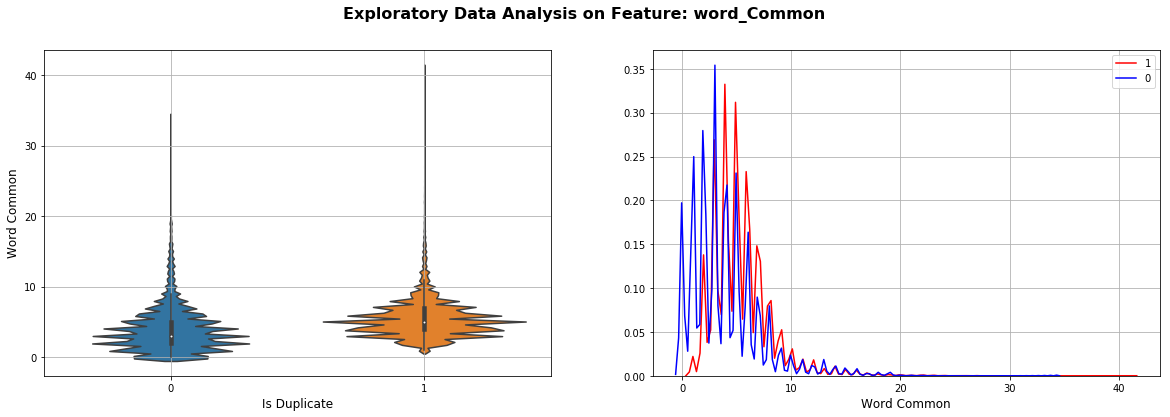

In [32]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_Common", data = quora_df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Word Common",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(quora_df[quora_df['is_duplicate'] == 1.0]['word_Common'], label = "1", color = "red", hist=False)
sns.distplot(quora_df[quora_df['is_duplicate'] == 0.0]['word_Common'], label = "0", color = "blue", hist=False)
plt.xlabel("Word Common",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: word_Common",fontsize=16,fontweight="bold")
plt.show()

<b>Observations</b>
- The distributions of the word_Common feature in similar and non-similar questions are highly/almost overlapping.

## 3.4 Preprocessing of Text(Questions)
- Removing html tags(using BeautifulSoup)
- Removing Punctuations/unecessary characters
- Converting to lowercase
- Performing stemming
- Removing Stopwords
- Expansion and contractions of some selected terms etc.

In [34]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001

nltk.download('stopwords')
stopwords= stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r'([0-9]+)000000',r'\1m',x)
    x = re.sub(r'([0-9]+)000',r'\1k',x)
    
    stem = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern,' ',x)
        
    if type(x) == type(''):
        example = BeautifulSoup(x)
        x = example.get_text()
        
    return x

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

<b>Definition:</b>
- __Token__: We get a token by splitting sentence with a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


<b>Token Features:</b>
- __cwc_min__ :  Ratio of common_word_count to min length of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
- __cwc_max__ :  Ratio of common_word_count to max length of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
- __csc_min__ :  Ratio of common_stop_count to min length of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
- __csc_max__ :  Ratio of common_stop_count to max length of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
- __ctc_min__ :  Ratio of common_token_count to min length of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
- __ctc_max__ :  Ratio of common_token_count to max length of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>     
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>
<b>Fuzzy and NLP Features:</b>
<br>
<br>
- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage  
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage  
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage  
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage  
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min length of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [35]:
def get_token_features(q1,q2):
    
    token_features = [0.0]*10
    
    #Converting questions to tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    #Getting all the non stopwords of questions
    q1_words = set([word for word in q1_tokens if word not in stopwords])
    q2_words = set([word for word in q2_tokens if word not in stopwords])
    
    #Getting all the stopwords of questions
    q1_stopwords = set([word for word in q1_tokens if word in stopwords])
    q2_stopwords = set([word for word in q2_tokens if word in stopwords])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stopwords.intersection(q2_stopwords))
    
    # Get the common tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count/(min(len(q1_words),len(q2_words))+ SAFE_DIV)
    token_features[1] = common_word_count/(max(len(q1_words),len(q2_words))+ SAFE_DIV)
    token_features[2] = common_stop_count/(min(len(q1_stopwords),len(q2_stopwords))+ SAFE_DIV)
    token_features[3] = common_stop_count/(max(len(q1_stopwords),len(q2_stopwords))+ SAFE_DIV)
    token_features[4] = common_token_count/(min(len(q1_tokens),len(q2_tokens))+ SAFE_DIV)
    token_features[5] = common_token_count/(max(len(q1_tokens),len(q2_tokens))+ SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features
 
# get the Longest Common sub string   
def get_longest_substr_ratio(q1,q2):
    strs = list(distance.lcsubstrings(q1,q2))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(q1), len(q2)) + 1)

def advanced_extract_features(df):
    
    # preprocessing each question
    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df['question2'] = df['question2'].fillna("").apply(preprocess)
    
    token_features = df.apply(lambda x:get_token_features(x['question1'],x['question2']),axis = 1)
    
    # Merging Features with dataset
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    # Computing Fuzzy Features and Merging with Dataset
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    
    #Longest Substring match Feature
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df      

In [36]:
import warnings
warnings.filterwarnings("ignore")

if os.path.isfile("advanced_nlp_features.csv"):
    quora_df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    quora_df.fillna('')
else:
    start = dt.now()
    quora_df = advanced_extract_features(quora_df)
    quora_df.to_csv("quora_advancedfeatures_train.csv",index = False)
    print("Extraction of NLP Adavnced Features completed :)")
    print("\nTime taken to run this cell :",dt.now() - start)

Extraction of NLP Adavnced Features completed :)

Time taken to run this cell : 0:56:51.554587


In [37]:
quora_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate  freq_qid1  \
0  what is the step by step guide to invest in sh...             0          1   
1  what would happen if the indian government sto...             0          4   
2  how can internet speed be increased by hacking...             0          1   
3  find the remainder when  math 23  24   math  i...             0          1   
4            which fish would survive in salt water              0          3   

   freq_qid2  q1len  q2len          ...            ctc_max  last_word_eq  \
0          1     66     57          ...           0.785709           0.0   
1          1     51     88          ...           0.466664           0.0   
2          1     73     59          ...           0.285712           0.0   
3          1     50     65          ...           0.000000           0.0   
4          1     76     39          ...           0.307690           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   
2            1.0           4.0      12.0               63                63   
3            0.0           2.0      12.0               28                24   
4            1.0           6.0      10.0               67                47   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  
2          43                  47              0.166667  
3           9                  14              0.039216  
4          35                  56              0.175000  

[5 rows x 32 columns]

### 3.5.1 Analysis of Advanced extracted features

#### 3.5.1.1 Plotting Word clouds
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [3]:
df_duplicate = quora_df[quora_df['is_duplicate'] == 1]
df_nonduplicate = quora_df[quora_df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array:
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))


#Saving the np array into a text file
np.savetxt('train_dup.txt', p, delimiter=',',fmt='%s',encoding = 'utf-8')
np.savetxt('train_nondup.txt', n, delimiter=',',fmt='%s',encoding = 'utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [6]:
# reading the text files and removing the Stop Words:

train_dup = open('train_dup.txt',encoding="utf-8").read()
train_nondup = open('train_nondup.txt',encoding="utf-8").read()

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

print ("Total number of words in duplicate pair questions :",len(p))
print ("Total number of words in non duplicate pair questions :",len(n))

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510054


<b>Word Clouds generated from duplicate pair question's text</b>

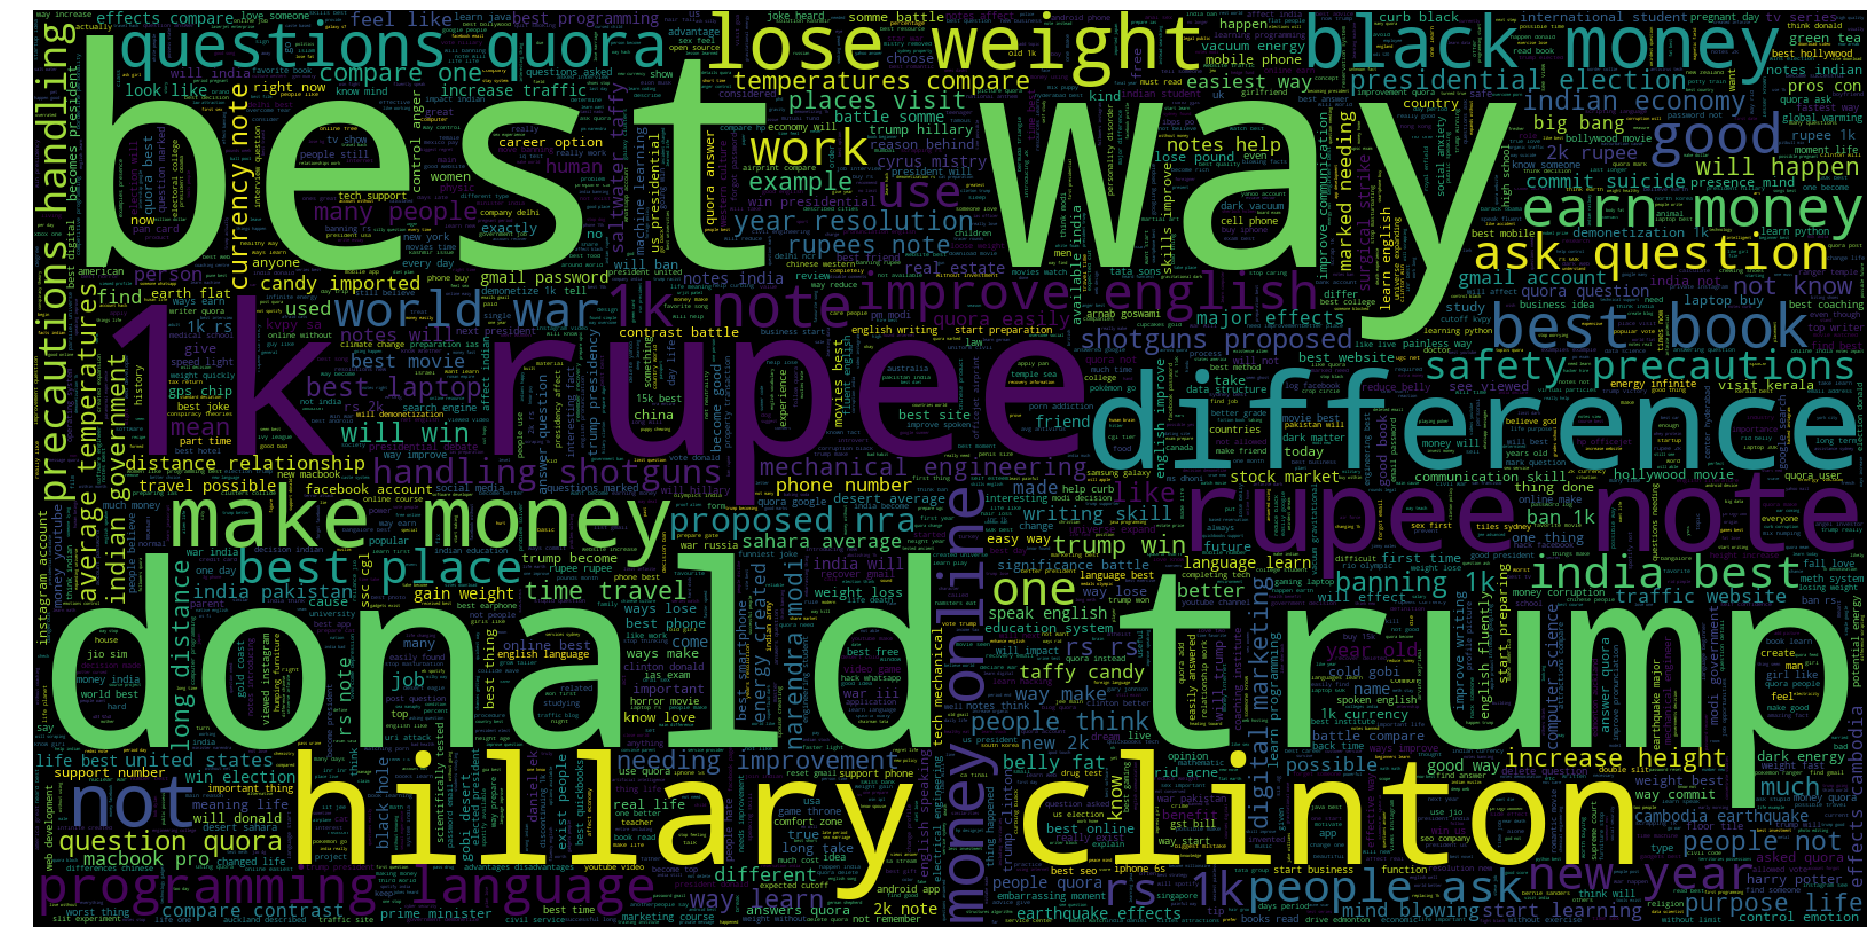

In [7]:
wc = WordCloud(background_color="black", max_words=len(train_dup), stopwords=stopwords, width=1600, height=800)
wc.generate(train_dup)
fig = plt.figure(figsize=(26,20))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<b>Word Clouds generated from non duplicate pair question's text</b>

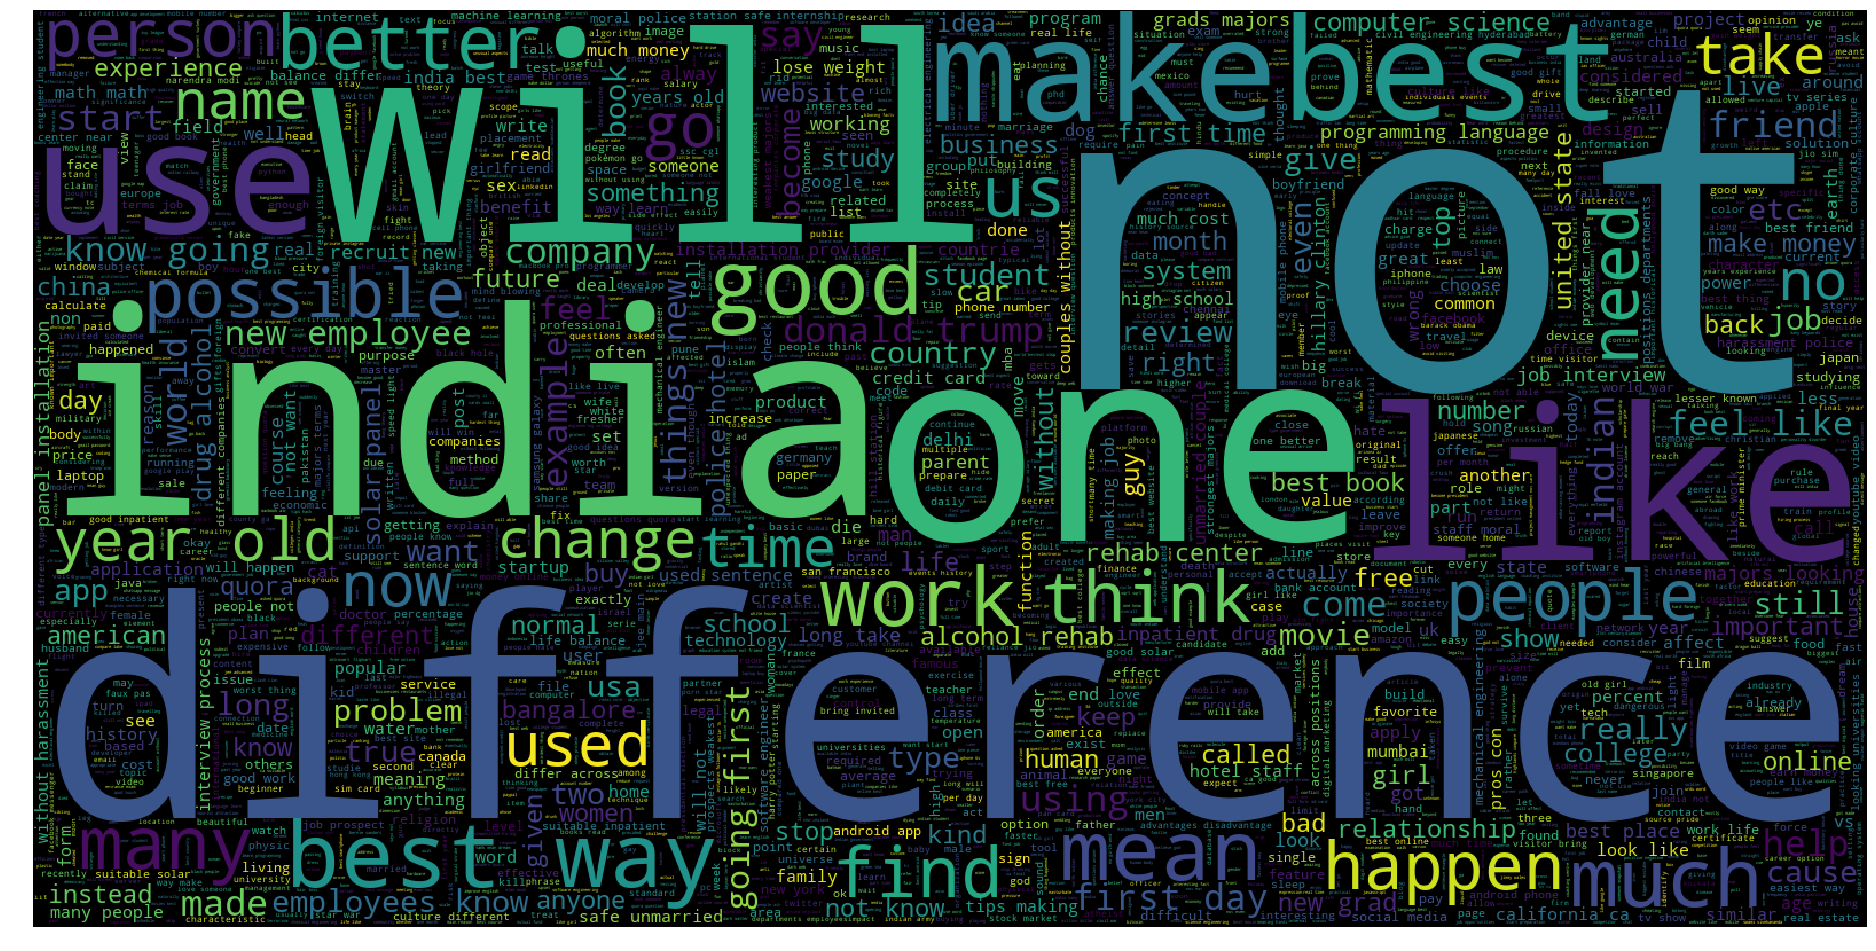

In [7]:
wc = WordCloud(background_color="black", max_words=len(train_nondup), stopwords=stopwords, width=1600, height=800)
wc.generate(train_nondup)
fig = plt.figure(figsize=(26,20))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<b>Observations</b>
-  From wordcloud, we can observe that words like <b>donald trump, hilary clinton, money, rupee, world war</b> etc occur frequently in <b>duplicate pairs questions</b>. We may conclude that there can be lot of <b>duplicate questions related to politics,leaders etc</b>.
-  Some terms like <b>make best</b> occur in <b>both duplicate and non-duplicate question pairs</b>,but occuring more frequently in one group as compared to other.

####  3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

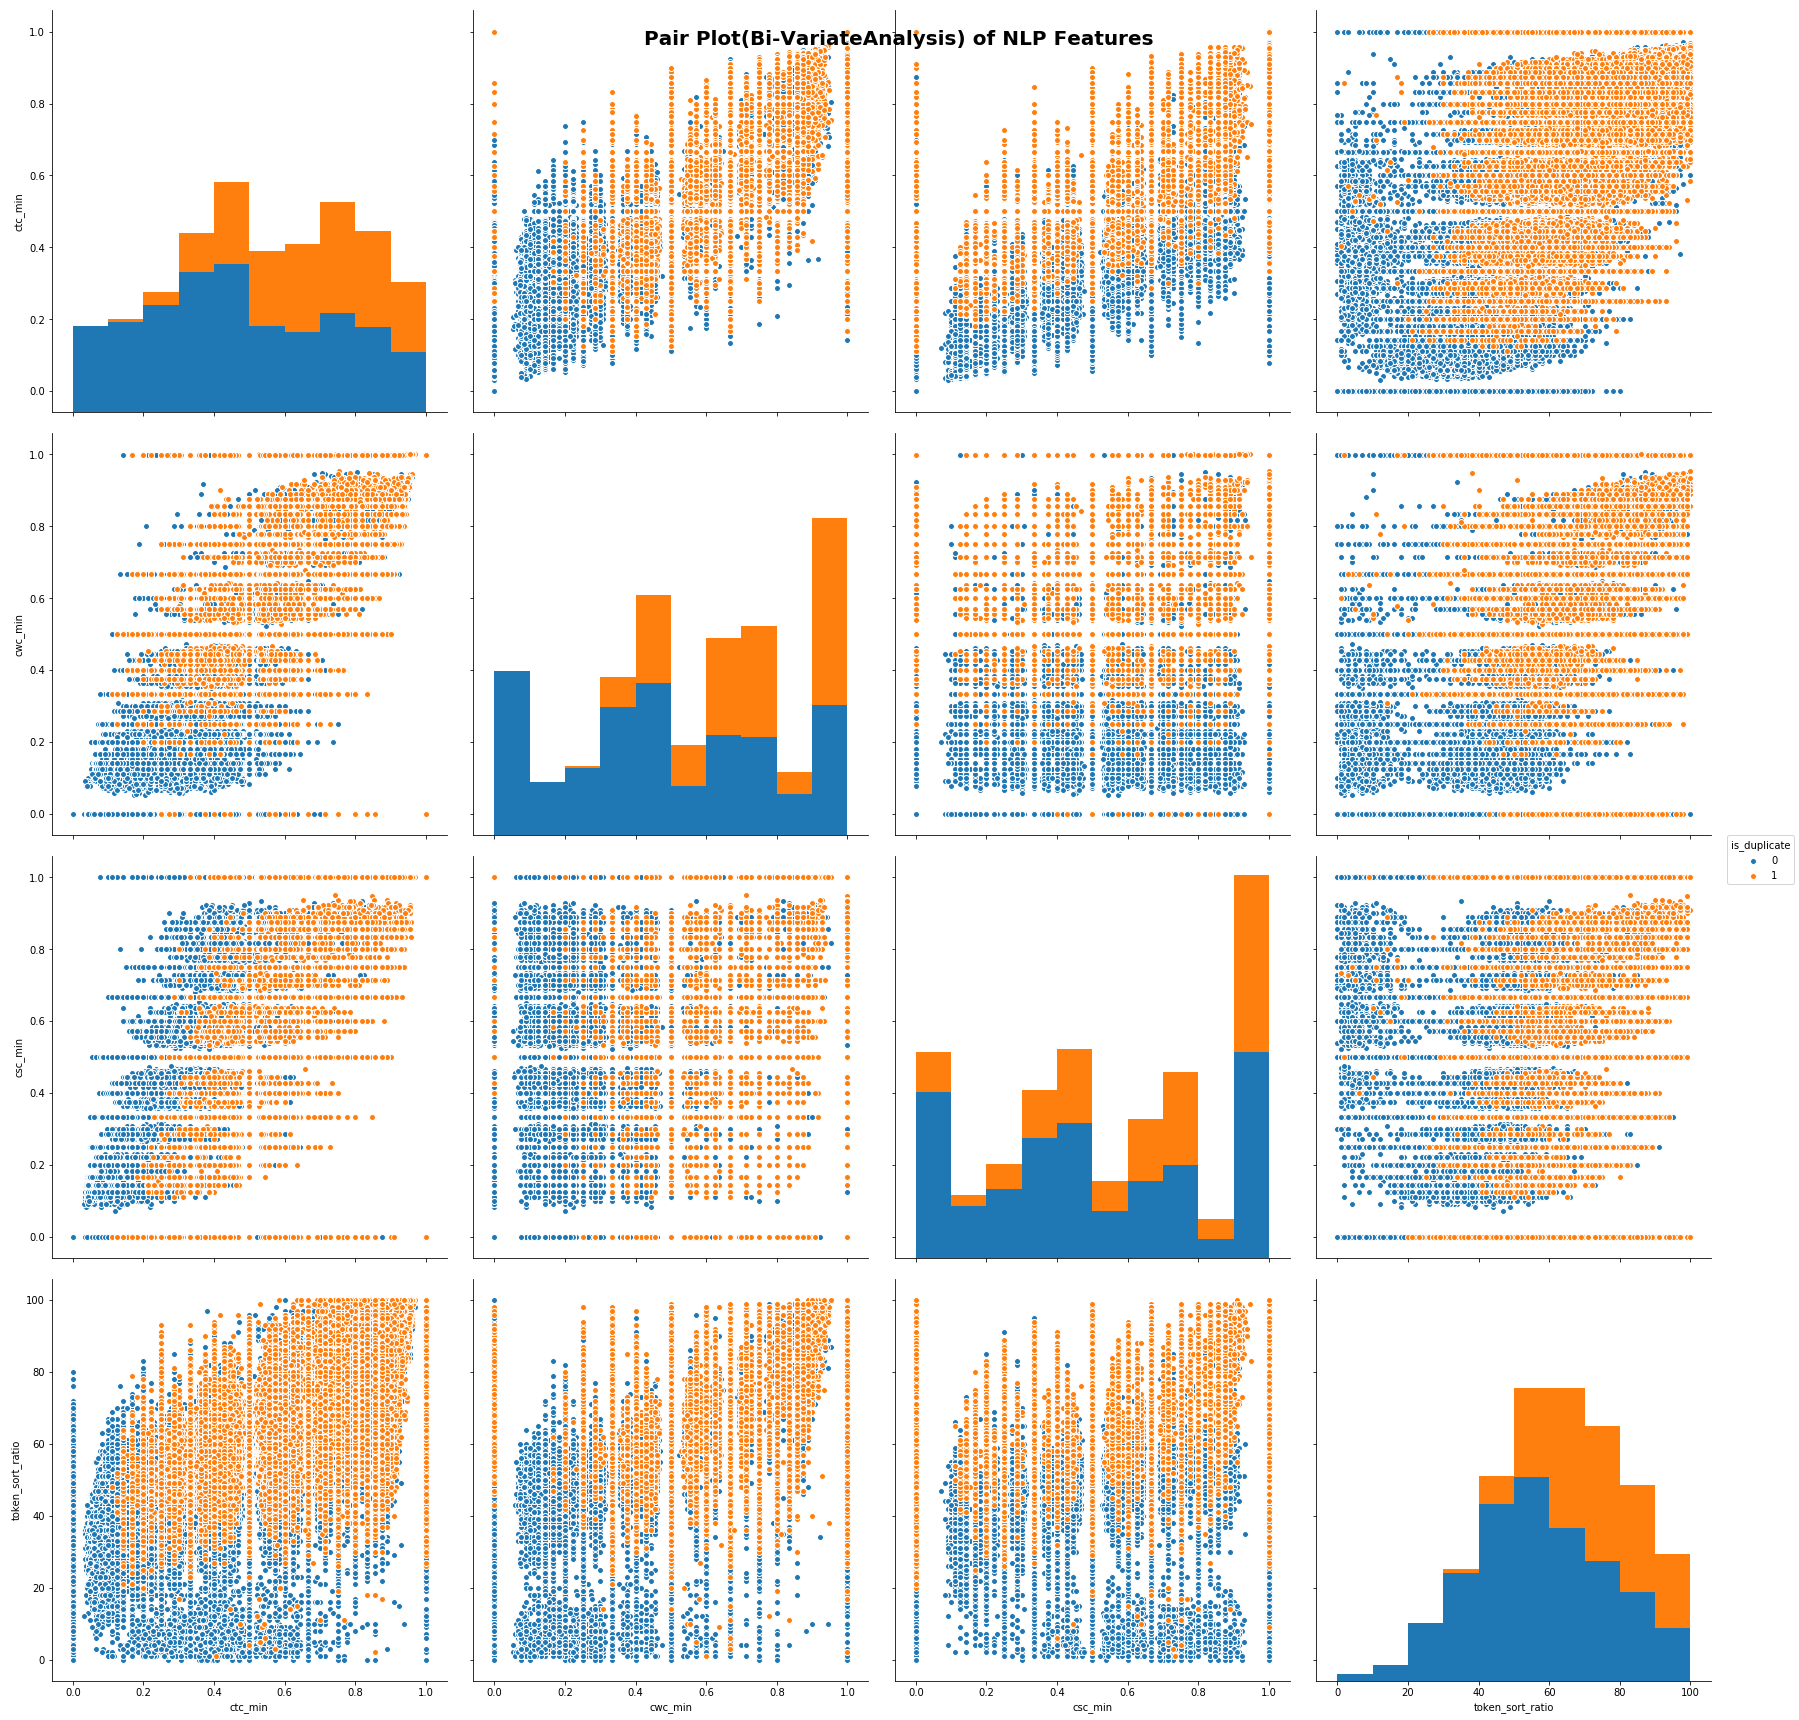

In [49]:
sns.pairplot(quora_df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'],size = 6)
plt.suptitle("Pair Plot(Bi-VariateAnalysis) of NLP Features",weight = 'bold').set_fontsize('20')
plt.show()

<b>Observations</b>
-  From pairplot between various features, we can observe that datapoints can be separated almost linearly using features like csc_min and ctc_min.
-  token_sort_ratio feature seems to be a good feature for classification of duplicate/non-dupliacte questions.

#### 3.5.1.3 EDA on Feature: token_sort_ratio

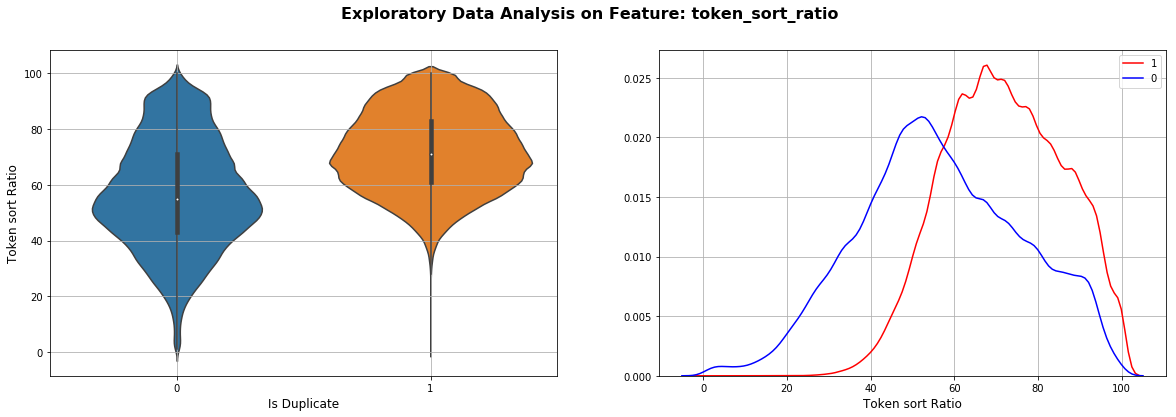

In [43]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "token_sort_ratio", data = quora_df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Token sort Ratio",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(quora_df[quora_df['is_duplicate'] == 1.0]['token_sort_ratio'], label = "1", color = "red", hist=False)
sns.distplot(quora_df[quora_df['is_duplicate'] == 0.0]['token_sort_ratio'], label = "0", color = "blue", hist=False)
plt.xlabel("Token sort Ratio",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: token_sort_ratio",fontsize=16,fontweight="bold")
plt.show()

<b>Observations</b>
- From violin plot,the average token sort ratio of qid1 and qid2 is more when they are duplicate(Similar)
- From pdf plot, te distributions for token_sort_ratio have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.

### 3.5.2 TSNE Visualization

#### 3.5.2.1 TSNE Visualization of all extracted features in 2D space

In [20]:
#tsne visualization for 10k samples(as tsne is computationally expensive)
df_subsampled = quora_df[0:10000]
X = MinMaxScaler().fit_transform(df_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
Y = df_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    perplexity = 40,
    init='random',
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

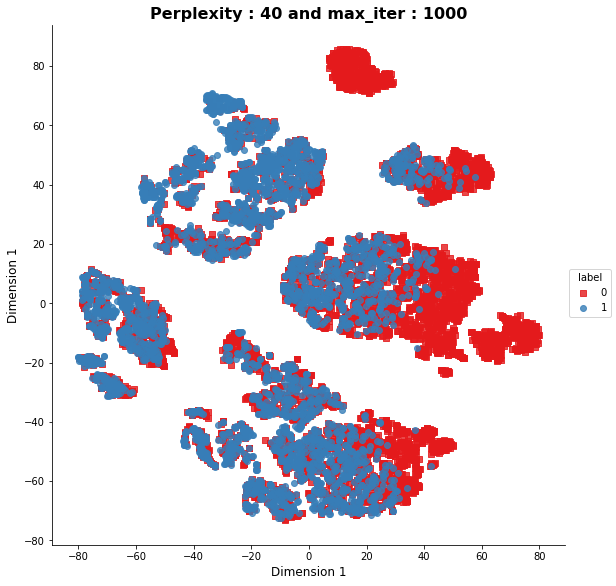

In [95]:
tsne2d_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':Y})


sns.lmplot(data=tsne2d_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("Perplexity : {} and max_iter : {}".format(40, 1000),fontsize = 16,fontweight = 'bold')
plt.xlabel("Dimension 1",fontsize = 12)
plt.ylabel("Dimension 1",fontsize = 12)
plt.show()

#### 3.5.2.2 TSNE Visualization of all extracted features in 3D space

In [ ]:
tsn3d = TSNE(
    n_components=3,
    perplexity = 40,
    init='random',
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)


x,y,z = tsn3d[:,0].tolist(),tsn3d[:,1].tolist(),tsn3d[:,2].tolist()
tsne3d_df = pd.DataFrame(
    {'X Label': x,
     'Y Label': y,
     'Z Label': z,
     'Label': Y.tolist()
    })

tsne3d_0 = tsne3d_df.loc[tsne3d_df['Label'] == 0]
tsne3d_1 = tsne3d_df.loc[tsne3d_df['Label'] == 1]

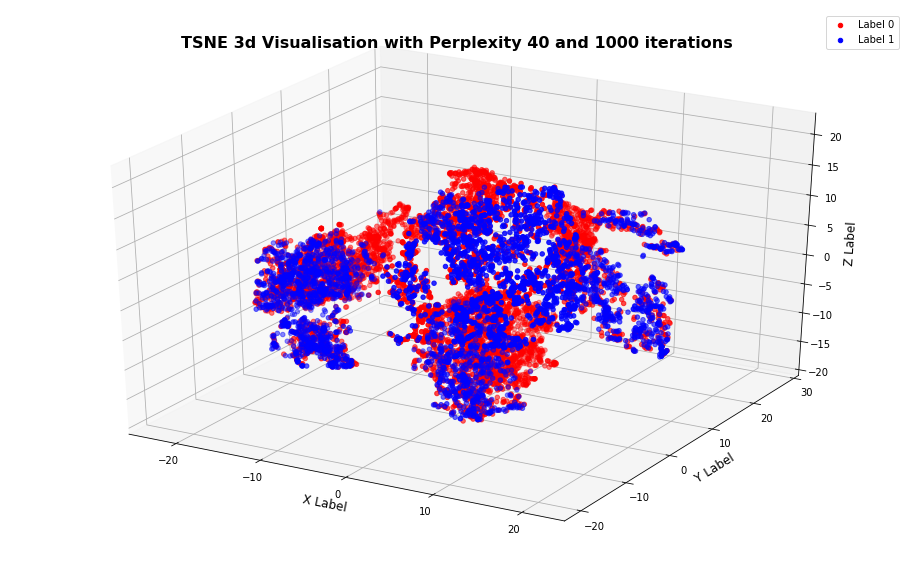

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3d_0['X Label'], tsne3d_0['Y Label'], tsne3d_0['Z Label'],c ='r',label='Label 0', marker='o')
ax.scatter(tsne3d_1['X Label'], tsne3d_1['Y Label'], tsne3d_1['Z Label'],c = 'b',label='Label 1', marker='o')
ax.set_xlabel('X Label',fontsize = 12)
ax.set_ylabel('Y Label',fontsize = 12)
ax.set_zlabel('Z Label',fontsize = 12)
ax.set_title("TSNE 3d Visualisation with Perplexity 40 and 1000 iterations",fontsize = 16,fontweight ='bold')
ax.legend()

plt.show()

<b>Observations</b>
- From both 2D and 3D TSNE visulisation,there are a lot of regions where non-duplicate question pairs are separately and densly clustered.
- There are also regions which tends to have some overlapping between duplicate and non-duplicate question pairs.

# 4. FEATURIZATION OF TEXT DATA(TF-IDF FEATURES)
<img src="https://cdn-images-1.medium.com/max/1600/1*jNnpbGPxkjehlvTCXq9B8g.png" width="500">

## 4.1 Converting questions to tfidf features

In [3]:
#Converting q1 to tfidf features
tfidf_q1 = TfidfVectorizer(lowercase = False,max_features = 10000,ngram_range = (1,1))
tfidf_q1_feats = tfidf_q1.fit_transform(list(quora_df['question1']))

#Converting q1 to tfidf features
tfidf_q2 = TfidfVectorizer(lowercase = False,max_features = 10000,ngram_range = (1,1)) 
tfidf_q2_feats = tfidf_q2.fit_transform(list(quora_df['question2']))

In [4]:
if os.path.isfile('quora_advancedfeatures_train.csv'):
    df_advanced = pd.read_csv("quora_advancedfeatures_train.csv",encoding='latin-1')
else:
    print("quora_advancedfeatures_train.csv doesnot exist.")

if os.path.isfile('quora_basicfeatures_without_preprocessing_train.csv'):
    df_basic = pd.read_csv("quora_basicfeatures_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("quora_basicfeatures_without_preprocessing_train.csv doesnot exist.")

In [5]:
df = pd.read_csv("train.csv")

df1 = df_advanced.drop(['id','qid1','qid2','question1','question2','is_duplicate','freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words','q2_n_words', 'word_Common', 'word_Total', 'word_share','freq_q1+freq_q2', 'freq_q1-freq_q2'],axis=1)
df2 = df_basic.drop(['id','qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = tfidf_q1_feats.tocsr()
df3_q2 = tfidf_q2_feats.tocsr()

In [6]:
# dataframe of nlp adavnced and fuzzy features
df1.head()

cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  last_word_eq  \
0  0.999980  0.833319  0.999983  0.999983  0.916659  0.785709           0.0   
1  0.799984  0.399996  0.749981  0.599988  0.699993  0.466664           0.0   
2  0.399992  0.333328  0.399992  0.249997  0.399996  0.285712           0.0   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000           0.0   
4  0.399992  0.199998  0.999950  0.666644  0.571420  0.307690           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   
2            1.0           4.0      12.0               63                63   
3            0.0           2.0      12.0               28                24   
4            1.0           6.0      10.0               67                47   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  
2          43                  47              0.166667  
3           9                  14              0.039216  
4          35                  56              0.175000

In [7]:
# dataframe of basic features before preprocessing 
df2.head()

freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  \
0          1          1     66     57          14          12         10.0   
1          4          1     51     88           8          13          4.0   
2          1          1     73     59          14          10          4.0   
3          1          1     50     65          11           9          0.0   
4          3          1     76     39          13           7          2.0   

   word_Total  word_share  freq_q1+freq_q2  freq_q1-freq_q2  
0        23.0    0.434783                2                0  
1        20.0    0.200000                5                3  
2        24.0    0.166667                2                0  
3        19.0    0.000000                2                0  
4        20.0    0.100000                4                2

In [8]:
print("Number of features in nlp advanced dataframe :", df1.shape[1])
print("Number of features in before preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 tfidf  :", df3_q1.shape[1])
print("Number of features in question2 tfidf  :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp advanced dataframe : 15
Number of features in before preprocessed dataframe : 11
Number of features in question1 tfidf  : 10000
Number of features in question2 tfidf  : 10000
Number of features in final dataframe  : 20026


## 4.2 Merging of all advanced,basic and tfidf features

In [9]:
df1=np.array(df1)
df2=np.array(df2)

df1  = hstack((df1,df3_q1))
final_df  = hstack((df1,df3_q2))
print("Number of features in Train:",final_df.shape[1])

Number of features in Train: 20015


# 5. MACHINE LEARNING MODELS WITH TFIDF FEATURES

Here we will apply three different ML models:
-  Logistic Regression
-  Linear SVM
-  Xgboost Classification

## 5.1 Random train test split(70:30)

In [10]:
y_true = quora_df['is_duplicate']
y_true = list(map(int,y_true.values))

In [11]:
X_train,X_test,y_train,y_test = train_test_split(final_df, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 20015)
Number of data points in test data : (121287, 20015)


In [12]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


### 5.1.1 Standarization on Input Data
-  We feed standarized input data only for Logistic Regression and SVM models as both the models use distance best methods to find the best hyperplane.
-  No standarization is required for Xgboost as it is independent of distance based methods.

In [13]:
scaler=StandardScaler(with_mean=False)
X_train_std=scaler.fit_transform(X_train)

In [14]:
X_test_std=scaler.transform(X_test)

## 5.2 Plotting binary confusion, precision and recall matrix

In [15]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## 5.3 Training of Models

### Building a random model (Finding worst-case log-loss)
Since log-loss∈(0,∞), let us find the worst log-loss using a random(dumb) model.

Log loss on Test Data using Random Model 0.8891011727082314


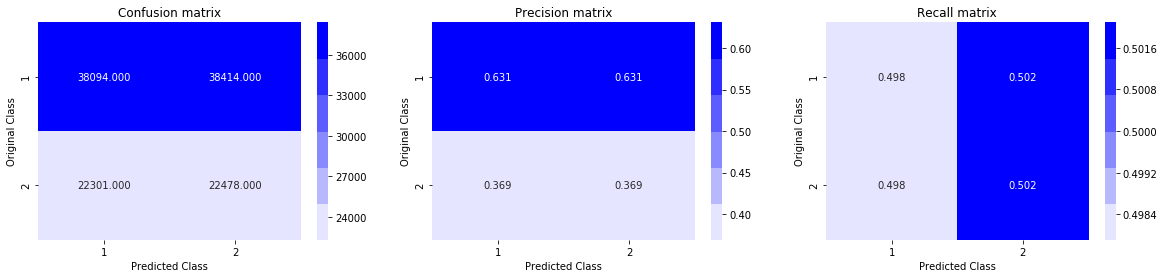

In [16]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<b>Observations</b>
-  We got Log loss on Test Data using Random Model as 0.889.
-  So any ML model we build, we want our log-loss to be between 0 and 0.889. 

### 5.3.1 Logistic Regression(SGD Classifier with loss "log")

For values of alpha =  1e-05 The log loss is: 0.506574335336078
For values of alpha =  0.0001 The log loss is: 0.5058353034714629
For values of alpha =  0.001 The log loss is: 0.5035512440205062
For values of alpha =  0.01 The log loss is: 0.45240624333448104
For values of alpha =  0.1 The log loss is: 0.4342529482677594
For values of alpha =  1 The log loss is: 0.4574646674782553
For values of alpha =  10 The log loss is: 0.5276411418285952


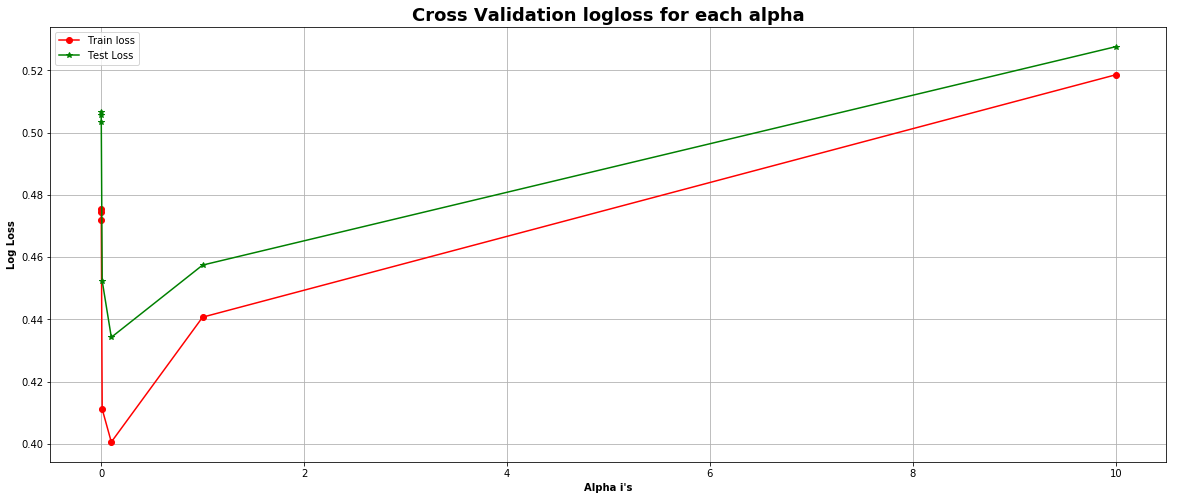


For values of best alpha =  0.1 The train log loss is: 0.40059922716056273
For values of best alpha =  0.1 The test log loss is: 0.4342529482677594
Total number of data points : 121287


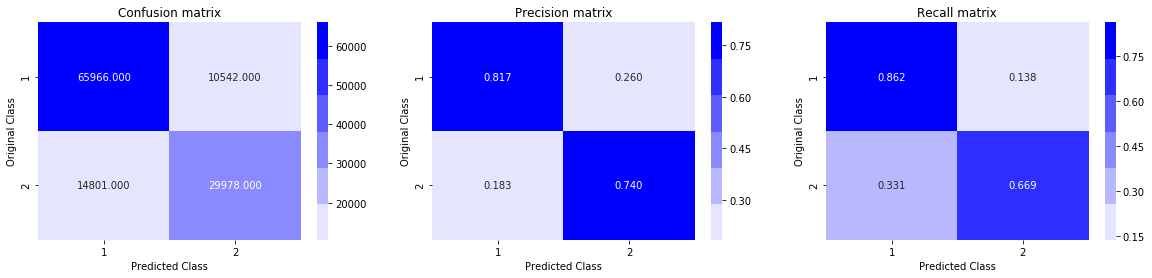

In [63]:
import warnings
warnings.filterwarnings("ignore")

#hyperparameter
alpha = [10 ** x for x in range(-5, 2)]

trainlog_error_array=[] 
testlog_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=9)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_ytrain = sig_clf.predict_proba(X_train_std)
    predict_ytest = sig_clf.predict_proba(X_test_std)
    trainlog_error_array.append(log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
    testlog_error_array.append(log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))

#Plot between train and test loss
plt.figure(figsize=(20,8))
plt.plot(alpha, trainlog_error_array,'r-o',label="Train loss")
plt.plot(alpha, testlog_error_array,'g-*',label="Test Loss")
plt.title("Cross Validation logloss for each alpha",fontweight="bold",fontsize = 18)
plt.xlabel("Alpha i's",fontweight="bold")
plt.ylabel("Log Loss",fontweight="bold")
plt.legend()
plt.grid()
plt.show()


#Model with best hyperparameter
best_alpha = np.argmin(testlog_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=9)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

#Logloss and binary confusion,precision and recall matrix
predict_ytrain = sig_clf.predict_proba(X_train_std)
print('\nFor values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
predict_ytest = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_ytest,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### 5.3.2 Linear SVM(SGD Classifier with loss "hinge")

For values of alpha =  1e-05 The log loss is: 0.51307630594674
For values of alpha =  0.0001 The log loss is: 0.5352736622423596
For values of alpha =  0.001 The log loss is: 0.6036744696878971
For values of alpha =  0.01 The log loss is: 0.6566121525843709
For values of alpha =  0.1 The log loss is: 0.658398214210334
For values of alpha =  1 The log loss is: 0.6584745292997076
For values of alpha =  10 The log loss is: 0.6585058076795598


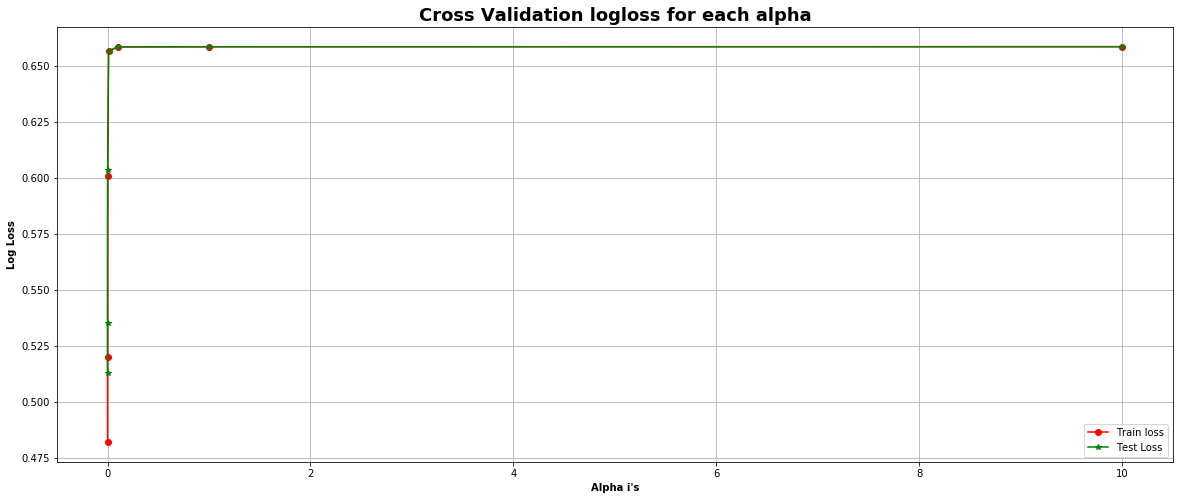


For values of best alpha =  1e-05 The train log loss is: 0.4821702353632736
For values of best alpha =  1e-05 The test log loss is: 0.51307630594674
Total number of data points : 121287


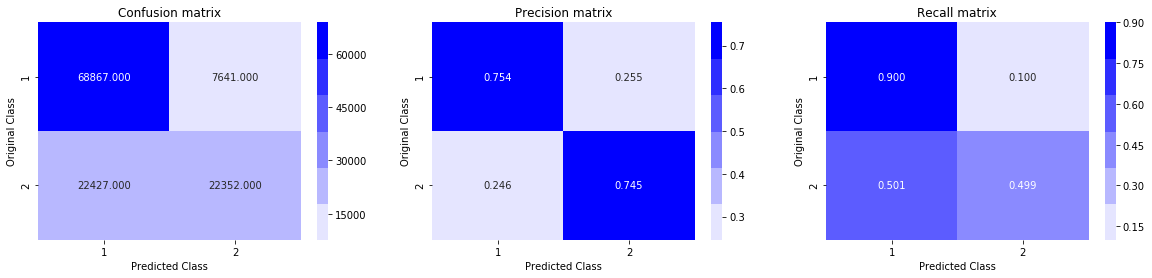

In [64]:
warnings.filterwarnings("ignore")

#hyperparameter
alpha = [10 ** x for x in range(-5, 2)]

trainlog_error_array=[] 
testlog_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=9)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_ytrain = sig_clf.predict_proba(X_train_std)
    predict_ytest = sig_clf.predict_proba(X_test_std)
    trainlog_error_array.append(log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
    testlog_error_array.append(log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))

#Plot between train and test loss
plt.figure(figsize=(20,8))
plt.plot(alpha, trainlog_error_array,'r-o',label="Train loss")
plt.plot(alpha, testlog_error_array,'g-*',label="Test Loss")
plt.title("Cross Validation logloss for each alpha",fontweight="bold",fontsize = 18)
plt.xlabel("Alpha i's",fontweight="bold")
plt.ylabel("Log Loss",fontweight="bold")
plt.legend()
plt.grid()
plt.show()

#Model with best hyperparameter
best_alpha = np.argmin(testlog_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1' , loss='hinge', random_state=9)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

#Logloss and binary confusion,precision and recall matrix
predict_ytrain = sig_clf.predict_proba(X_train_std)
print('\nFor values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
predict_ytest = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_ytest,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### 5.3.3 XGBoost Classifier

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 53.6min finished


Logloss: 0.460108 with: {'colsample_bytree': 0.9, 'gamma': 0.20037491842974775, 'learning_rate': 0.10915465862682922, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 25, 'reg_alpha': 0.8772212074585868, 'subsample': 0.6}
Logloss: 0.437686 with: {'colsample_bytree': 0.7, 'gamma': 0.1277226553619797, 'learning_rate': 0.08917717001661456, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 131, 'reg_alpha': 0.3739511814040245, 'subsample': 0.9}
Logloss: 0.413414 with: {'colsample_bytree': 0.5, 'gamma': 0.2935808162377885, 'learning_rate': 0.15030968930238459, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 123, 'reg_alpha': 0.6668989729196366, 'subsample': 0.6}
Logloss: 0.427538 with: {'colsample_bytree': 0.6, 'gamma': 0.288661380688067, 'learning_rate': 0.13591020568376583, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 59, 'reg_alpha': 0.3752093449513596, 'subsample': 0.6}
Logloss: 0.426705 with: {'colsample_bytree': 1.0, 'gamma': 0.12089159066920914, 'learning_

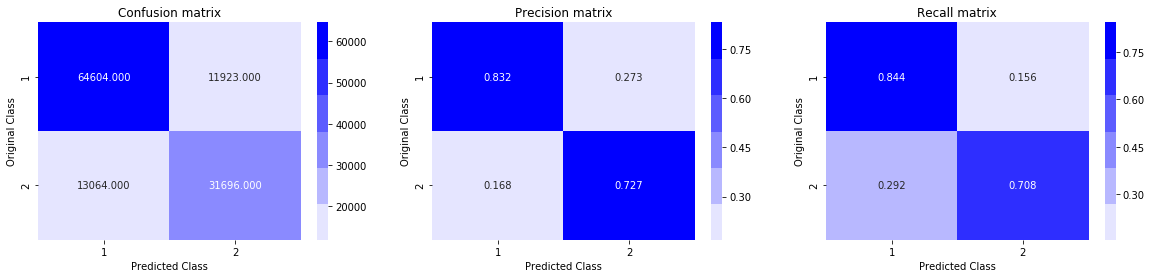

['xgb_estimator.pkl']

In [19]:
#xgboost hyperparameters
param_xgb = {"learning_rate":st.uniform(0.01,0.2),
             "n_estimators":st.randint(3,200),
             "max_depth":st.randint(3,10),
             "min_child_weight":st.randint(1,6),
             "gamma":st.uniform(0.1,0.2),
             "reg_alpha":st.uniform(0,1),
             "subsample":[0.6,0.7,0.8,0.9,1.0],
             "colsample_bytree":[0.5,0.6,0.7,0.8,0.9,1.0]
            }



clf = XGBClassifier(objective='binary:logistic')
randgrid = RandomizedSearchCV(clf, param_xgb, cv = 3, scoring = "log_loss", verbose = 1, random_state = 9)
xgb_estimator = randgrid.fit(X_train,y_train)

means = xgb_estimator.cv_results_['mean_test_score']
params = xgb_estimator.cv_results_['params']

for mean, param in zip(means, params):
    print("Logloss: %f with: %r" % (mean*(-1), param))

predict_y = xgb_estimator.predict_proba(X_test)
predicted_y = np.argmax(predict_y,axis=1)
print("\n\33[1mTrain logloss with best hyperparameters {} is\33[0m: {}".format(xgb_estimator.best_params_,xgb_estimator.best_score_*(-1)))
print("\n\33[1mTest logloss with tuned hyperparameters is\33[0m:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,predicted_y)

#joblib.dump(xgb_estimator,"xgb_estimator.pkl")

# 6. FEATURIZATION OF TEXT DATA(TF-IDF W2V FEATURES)
<img src="https://i.ytimg.com/vi/nHnML6fauDg/hqdefault.jpg" width="500">

### 6.1 Finding tfidf features on whole input data(questions 1 and questions 2)

In [10]:
questions = quora_df['question1'].values + quora_df['question2'].values

tfidf = TfidfVectorizer(lowercase = False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [11]:
list_of_ques=[]
for sent in questions:
    list_of_ques.append(sent.split())

### 6.2 Building w2v model on whole input data(questions 1 and questions 2)

In [12]:
start = dt.now()

min_count = 5
w2v_model = Word2Vec(list_of_ques, min_count = min_count, size = 384, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

print("Time taken to run this cell: ",dt.now() - start)

Time taken to run this cell:  0:01:05.365266


In [13]:
list_of_ques1=[]
for q1 in quora_df['question1'].values:
    list_of_ques1.append(q1.split())
    
list_of_ques2=[]
for q2 in quora_df['question2'].values:
    list_of_ques2.append(q2.split())

### 6.3 Finding tfidf w2v features for question 1

In [14]:
tfidf_feat = tfidf.get_feature_names()
vecs1 = []
row=0
for sent in tqdm(list_of_ques1):
    sent_vec = np.zeros(384)
    weight_sum =0
    for word in sent:
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
                tf_idf = word2tfidf[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    vecs1.append(sent_vec)
    row += 1

100%|██████████| 404290/404290 [06:27<00:00, 1043.25it/s]


### 6.4 Finding tfidf w2v features for question 2

In [15]:
vecs2 = []
row=0
for sent in tqdm(list_of_ques2):
    sent_vec = np.zeros(384)
    weight_sum =0
    for word in sent:
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
                tf_idf = word2tfidf[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    vecs2.append(sent_vec)
    row += 1

100%|██████████| 404290/404290 [06:24<00:00, 1051.76it/s]


In [16]:
df = pd.read_csv("train.csv")
df['q1_feats_m'] = list(vecs1)
df['q2_feats_m'] = list(vecs2)

df1 = df_advanced.drop(['qid1','qid2','question1','question2','freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words','q2_n_words', 'word_Common', 'word_Total', 'word_share','freq_q1+freq_q2', 'freq_q1-freq_q2'],axis=1)
df2 = df_basic.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [17]:
# dataframe of nlp features
df1.head()

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999980  0.833319  0.999983  0.999983  0.916659   
1   1             0  0.799984  0.399996  0.749981  0.599988  0.699993   
2   2             0  0.399992  0.333328  0.399992  0.249997  0.399996   
3   3             0  0.000000  0.000000  0.000000  0.000000  0.000000   
4   4             0  0.399992  0.199998  0.999950  0.666644  0.571420   

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.785709           0.0            1.0           2.0      13.0   
1  0.466664           0.0            1.0           5.0      12.5   
2  0.285712           0.0            1.0           4.0      12.0   
3  0.000000           0.0            0.0           2.0      12.0   
4  0.307690           0.0            1.0           6.0      10.0   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                 100   
1               86                63          66                  75   
2               63                63          43                  47   
3               28                24           9                  14   
4               67                47          35                  56   

   longest_substr_ratio  
0              0.982759  
1              0.596154  
2              0.166667  
3              0.039216  
4              0.175000

In [18]:
# datafarme of basic features before preprocessing 
df2.head()

id  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
0   0          1          1     66     57          14          12   
1   1          4          1     51     88           8          13   
2   2          1          1     73     59          14          10   
3   3          1          1     50     65          11           9   
4   4          3          1     76     39          13           7   

   word_Common  word_Total  word_share  freq_q1+freq_q2  freq_q1-freq_q2  
0         10.0        23.0    0.434783                2                0  
1          4.0        20.0    0.200000                5                3  
2          4.0        24.0    0.166667                2                0  
3          0.0        19.0    0.000000                2                0  
4          2.0        20.0    0.100000                4                2

In [19]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

0         1         2         3         4         5         6    \
0 -0.393733  0.138218  0.154090 -0.359489  0.500371  0.402571 -0.228317   
1 -0.179269  0.057888 -0.048987  0.064886 -0.064644 -0.009400  0.136815   
2 -0.085483  0.051510  0.403799 -0.050377  0.590438  0.681156 -0.532018   
3  0.324063 -0.045610 -0.273782 -0.619426 -0.646335 -0.741417 -0.238729   
4 -0.315215 -0.139924 -0.164289  0.332394 -0.340345 -0.255706 -0.074902   

        7         8         9      ...          374       375       376  \
0 -0.218713  0.233860 -0.152131    ...     0.999461 -0.285455  0.108566   
1  0.072889  0.041552  0.082883    ...     0.185365 -0.088134 -0.128650   
2  0.090110  0.636348  0.000638    ...     0.286418 -0.042650  0.426806   
3  0.034775  0.234117  0.023472    ...    -0.014779  0.030802  0.383786   
4 -0.301939  0.217367  0.070852    ...    -0.067923  0.155956 -0.004264   

        377       378       379       380       381       382       383  
0 -0.210336  0.094183  0.413697 -0.604862 -0.385804 -0.218603  0.371307  
1  0.040579  0.111377 -0.031965 -0.018974  0.059103 -0.045350  0.073070  
2  0.163577 -0.203604  0.127465  0.208678 -0.137766 -0.287956  0.600362  
3  0.018577 -0.301550 -0.189786 -0.031313 -0.035807 -0.127925 -0.272545  
4 -0.117462  0.115665 -0.249923  0.112699  0.009822  0.277976 -0.101042  

[5 rows x 384 columns]

In [20]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

0         1         2         3         4         5         6    \
0 -0.436647  0.234445  0.110836 -0.407680  0.569191  0.353748 -0.284011   
1 -0.397466  0.077322 -0.033985 -0.032987  0.081816  0.223834 -0.192312   
2  0.206303  0.044326  0.195716 -0.121053  0.311123  0.002105 -0.051326   
3 -0.119166  0.539686 -0.617924  0.077792 -0.205950 -0.147561  0.005393   
4 -0.721015  0.174339 -0.408096  0.240655 -0.490016  0.095837 -0.531860   

        7         8         9      ...          374       375       376  \
0 -0.161767  0.198961 -0.209742    ...     0.823587 -0.390284  0.070661   
1 -0.227192 -0.044948 -0.002144    ...     0.232188 -0.010444 -0.027027   
2 -0.146832  0.232097  0.005706    ...     0.248664  0.073816  0.391023   
3 -0.081136 -0.023203  0.296885    ...     0.521334  0.171917 -0.000921   
4 -0.312169  0.448591  0.163567    ...    -0.027375 -0.073510  0.155515   

        377       378       379       380       381       382       383  
0 -0.117608  0.118914  0.524165 -0.708602 -0.491204 -0.190785  0.503411  
1 -0.145765  0.149590  0.163285 -0.006358 -0.195248 -0.144421 -0.026667  
2  0.011892 -0.153758  0.158384  0.038138 -0.445059 -0.243802  0.159816  
3 -0.258408  0.046434  0.443151  0.065143  0.458937 -0.045803 -0.063218  
4 -0.178536 -0.220089 -0.501727 -0.103101 -0.186005 -0.042932 -0.348058  

[5 rows x 384 columns]

In [21]:
print("Number of features in nlp advanced dataframe :", df1.shape[1])
print("Number of features in before preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 tfidf w2v :", df3_q1.shape[1])
print("Number of features in question2 tfidf w2v :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp advanced dataframe : 17
Number of features in before preprocessed dataframe : 12
Number of features in question1 tfidf w2v : 384
Number of features in question2 tfidf w2v : 384
Number of features in final dataframe  : 797


### 6.5 Merging of all advanced,basic and tfidfw2v features

In [22]:
# storing the final features to csv file
if not os.path.isfile('final_features_tfidfw2v.csv'):
    df3_q1.insert(loc=0, column='id', value=np.arange(0,df3_q1.shape[0]))
    df3_q2.insert(loc=0, column='id', value=np.arange(0,df3_q2.shape[0]))
    final_df  = pd.merge(df1,df2, on='id')
    final_df  = pd.merge(final_df, df3_q1,on='id')
    final_df  = pd.merge(final_df, df3_q2,on='id')

In [23]:
y_true = final_df['is_duplicate']
y_true = list(map(int, y_true.values))
final_df.drop(['id','is_duplicate'], axis=1, inplace=True)
final_df.head()

cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  last_word_eq  \
0  0.999980  0.833319  0.999983  0.999983  0.916659  0.785709           0.0   
1  0.799984  0.399996  0.749981  0.599988  0.699993  0.466664           0.0   
2  0.399992  0.333328  0.399992  0.249997  0.399996  0.285712           0.0   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000           0.0   
4  0.399992  0.199998  0.999950  0.666644  0.571420  0.307690           0.0   

   first_word_eq  abs_len_diff  mean_len    ...        374_y     375_y  \
0            1.0           2.0      13.0    ...     0.823587 -0.390284   
1            1.0           5.0      12.5    ...     0.232188 -0.010444   
2            1.0           4.0      12.0    ...     0.248664  0.073816   
3            0.0           2.0      12.0    ...     0.521334  0.171917   
4            1.0           6.0      10.0    ...    -0.027375 -0.073510   

      376_y     377_y     378_y     379_y     380_y     381_y     382_y  \
0  0.070661 -0.117608  0.118914  0.524165 -0.708602 -0.491204 -0.190785   
1 -0.027027 -0.145765  0.149590  0.163285 -0.006358 -0.195248 -0.144421   
2  0.391023  0.011892 -0.153758  0.158384  0.038138 -0.445059 -0.243802   
3 -0.000921 -0.258408  0.046434  0.443151  0.065143  0.458937 -0.045803   
4  0.155515 -0.178536 -0.220089 -0.501727 -0.103101 -0.186005 -0.042932   

      383_y  
0  0.503411  
1 -0.026667  
2  0.159816  
3 -0.063218  
4 -0.348058  

[5 rows x 794 columns]

# 7. MACHINE LEARNING MODELS WITH TFIDF W2V FEATURES

Here we will apply three different ML models:
-  Logistic Regression
-  Linear SVM
-  Xgboost Classification

In [24]:
# Random train test split(70:30)
X_train,X_test, y_train, y_test = train_test_split(final_df, y_true,stratify=y_true,test_size=0.3)

In [25]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 794)
Number of data points in test data : (121287, 794)


In [26]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.6308013224830361 Class 1:  0.3691986775169639


#### Standarization on Input Data
-  We feed standarized input data only for Logistic Regression and SVM models as both the models use distance best methods to find the best hyperplane.
-  No standarization is required for Xgboost as it is independent of distance based methods.

In [27]:
scaler=StandardScaler(with_mean=False)
X_train_std=scaler.fit_transform(X_train)

In [28]:
X_test_std=scaler.transform(X_test)

## 7.1 Logistic Regression(SGD Classifier with loss "log")

For values of alpha =  1e-05 The log loss is: 0.43894356280789665
For values of alpha =  0.0001 The log loss is: 0.4391342683658022
For values of alpha =  0.001 The log loss is: 0.42497198024295507
For values of alpha =  0.01 The log loss is: 0.4062868782924869
For values of alpha =  0.1 The log loss is: 0.4395223780292056
For values of alpha =  1 The log loss is: 0.490579260474821
For values of alpha =  10 The log loss is: 0.539630774808391


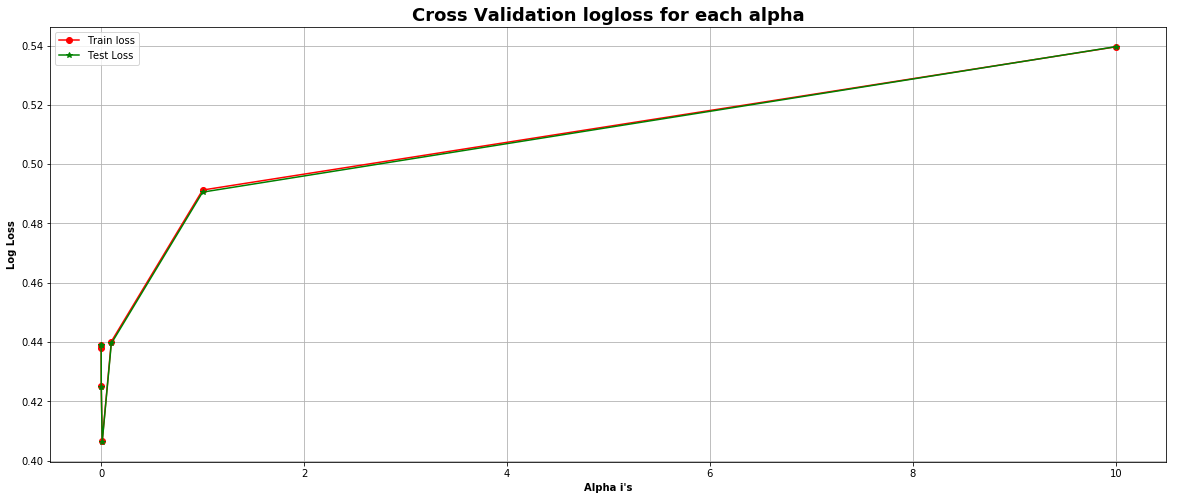


For values of best alpha =  0.01 The train log loss is: 0.40649013587544464
For values of best alpha =  0.01 The test log loss is: 0.4062868782924869
Total number of data points : 121287


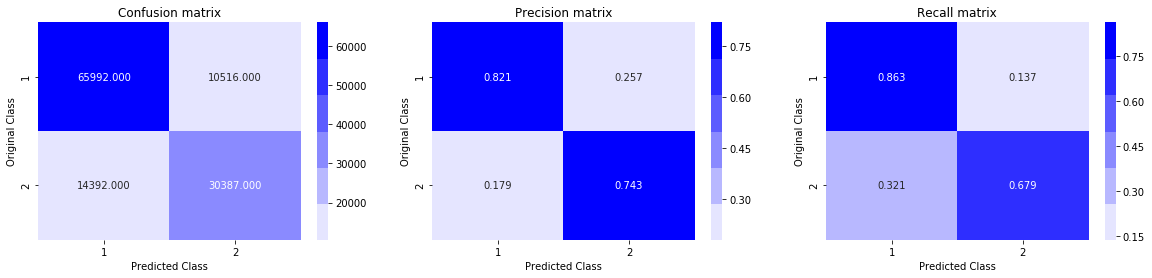

In [29]:
import warnings
warnings.filterwarnings("ignore")

alpha = [10 ** x for x in range(-5, 2)]

trainlog_error_array=[] 
testlog_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=9)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_ytrain = sig_clf.predict_proba(X_train_std)
    predict_ytest = sig_clf.predict_proba(X_test_std)
    trainlog_error_array.append(log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
    testlog_error_array.append(log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))

#Plot bw Train and test loss
plt.figure(figsize=(20,8))
plt.plot(alpha, trainlog_error_array,'r-o',label="Train loss")
plt.plot(alpha, testlog_error_array,'g-*',label="Test Loss")
plt.title("Cross Validation logloss for each alpha",fontweight="bold",fontsize = 18)
plt.xlabel("Alpha i's",fontweight="bold")
plt.ylabel("Log Loss",fontweight="bold")
plt.legend()
plt.grid()
plt.show()

#Model with best hyperparameter
best_alpha = np.argmin(testlog_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=9)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

#Logloss and binary confusion,precision and recall matrix
predict_ytrain = sig_clf.predict_proba(X_train_std)
print('\nFor values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
predict_ytest = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_ytest,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 7.2 Linear SVM(SGD Classifier with loss "hinge")

For values of alpha =  1e-05 The log loss is: 0.4251491250262493
For values of alpha =  0.0001 The log loss is: 0.45802579142329275
For values of alpha =  0.001 The log loss is: 0.48929123591303436
For values of alpha =  0.01 The log loss is: 0.4136958295587591
For values of alpha =  0.1 The log loss is: 0.5237348940586137
For values of alpha =  1 The log loss is: 0.6585278256322723
For values of alpha =  10 The log loss is: 0.6585278256322723


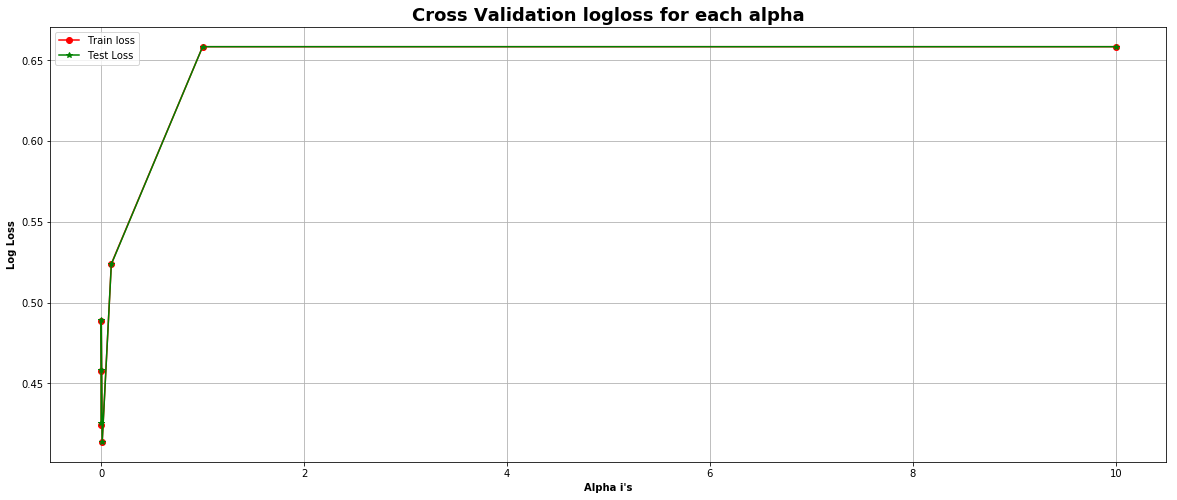


For values of best alpha =  0.01 The train log loss is: 0.4136182286066553
For values of best alpha =  0.01 The test log loss is: 0.4136958295587591
Total number of data points : 121287


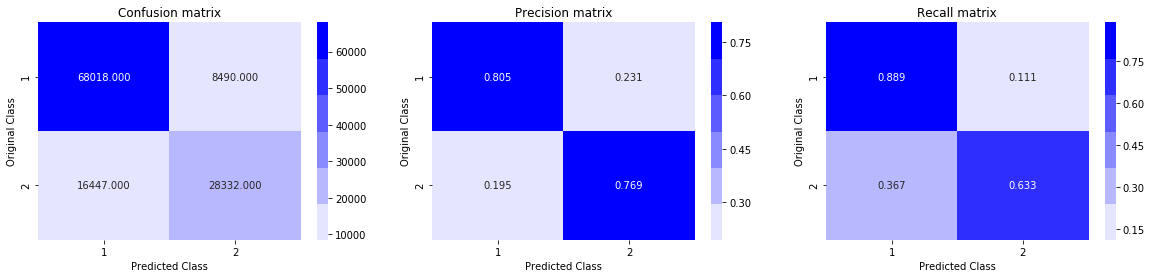

In [30]:
warnings.filterwarnings("ignore")

alpha = [10 ** x for x in range(-5, 2)]

trainlog_error_array=[] 
testlog_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=9)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_ytrain = sig_clf.predict_proba(X_train_std)
    predict_ytest = sig_clf.predict_proba(X_test_std)
    trainlog_error_array.append(log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
    testlog_error_array.append(log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))

#Plot bw Train and test loss
plt.figure(figsize=(20,8))
plt.plot(alpha, trainlog_error_array,'r-o',label="Train loss")
plt.plot(alpha, testlog_error_array,'g-*',label="Test Loss")
plt.title("Cross Validation logloss for each alpha",fontweight="bold",fontsize = 18)
plt.xlabel("Alpha i's",fontweight="bold")
plt.ylabel("Log Loss",fontweight="bold")
plt.legend()
plt.grid()
plt.show()

#Model with best hyperparameter
best_alpha = np.argmin(testlog_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1' , loss='hinge', random_state=9)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

#Logloss and binary confusion,precision and recall matrix
predict_ytrain = sig_clf.predict_proba(X_train_std)
print('\nFor values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ytrain, labels=clf.classes_, eps=1e-15))
predict_ytest = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_ytest,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 7.3 XGBoost Classification

Logloss : 0.369404 with {'colsample_bytree': 1.0, 'gamma': 0.20037491842974775, 'learning_rate': 0.10915465862682922, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 25, 'reg_alpha': 0.8772212074585868, 'subsample': 0.6}
Logloss : 0.339501 with {'colsample_bytree': 0.8, 'gamma': 0.1277226553619797, 'learning_rate': 0.08917717001661456, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 131, 'reg_alpha': 0.3739511814040245, 'subsample': 0.9}
Logloss : 0.323417 with {'colsample_bytree': 0.6, 'gamma': 0.2935808162377885, 'learning_rate': 0.15030968930238459, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 123, 'reg_alpha': 0.6668989729196366, 'subsample': 0.6}
Logloss : 0.331410 with {'colsample_bytree': 0.7, 'gamma': 0.288661380688067, 'learning_rate': 0.13591020568376583, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 59, 'reg_alpha': 0.3752093449513596, 'subsample': 0.6}
Logloss : 0.309410 with {'colsample_bytree': 0.9, 'gamma': 0.13392725151675344, 'learning_

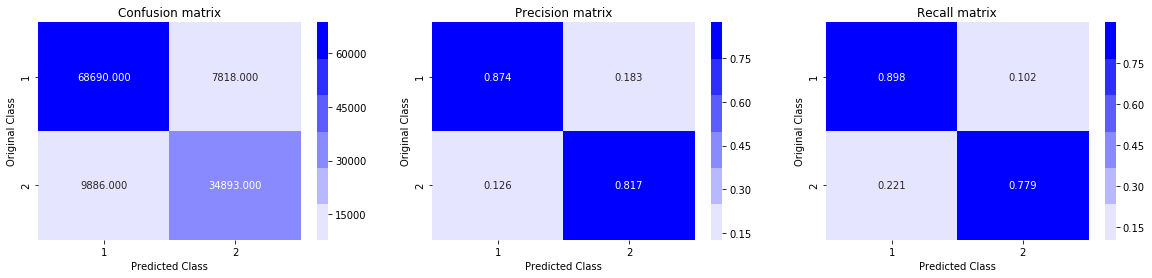

In [28]:
warnings.filterwarnings("ignore")

#xgboost hyperparameters
param_xgb = {"learning_rate":st.uniform(0.01,0.2),
             "n_estimators":st.randint(3,200),
             "max_depth":st.randint(3,10),
             "min_child_weight":st.randint(1,6),
             "gamma":st.uniform(0.1,0.2),
             "reg_alpha":st.uniform(0,1),
             "subsample":[0.6,0.7,0.8,0.9,1.0],
             "colsample_bytree":[0.6,0.7,0.8,0.9,1.0]
            }


clf = XGBClassifier(objective='binary:logistic')
randgrid = RandomizedSearchCV(clf, param_xgb, n_iter=10, cv = 3, scoring = "log_loss", random_state = 9)
xgb_estimator_tfidfw2v = randgrid.fit(X_train,y_train)means=xgb_estimator_tfidfw2v.cv_results_['mean_test_score']
params=xgb_estimator_tfidfw2v.cv_results_['params']

for mean,param in zip(means,params):
    print("Logloss : %f with %r" % (mean*(-1),param))

predict_y=xgb_estimator_tfidfw2v.predict_proba(X_test)
predicted_y=np.argmax(predict_y,axis=1)
print("\n\33[1mTrain Logloss with best hyperparameters {} is\33[0m: {}".format(xgb_estimator_tfidfw2v.best_params_,xgb_estimator_tfidfw2v.best_score_*(-1)))
print("\n\33[1mTest Logloss with tuned hyperparameters is\33[0m:",log_loss(y_test,predict_y))
plot_confusion_matrix(y_test,predicted_y)

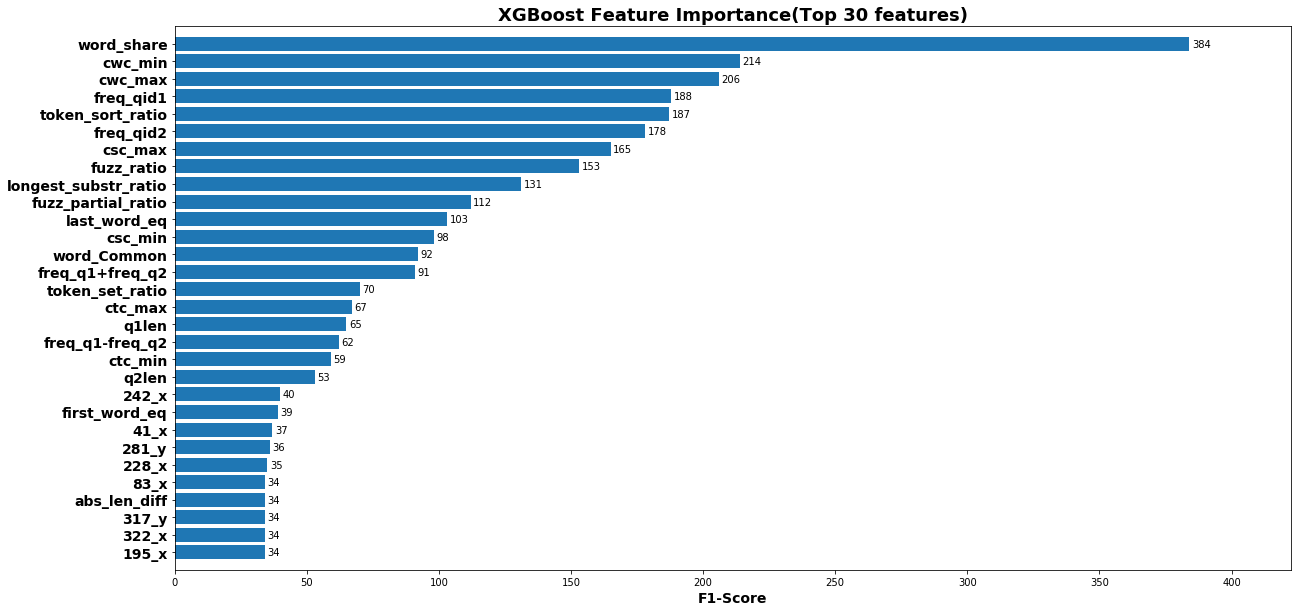

In [63]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(xgb_estimator_tfidfw2v.best_estimator_, height = 0.8 , ax = ax,  max_num_features = 30)
plt.title("XGBoost Feature Importance(Top 30 features)",fontsize=18, fontweight = "bold")
plt.xlabel("F1-Score",fontsize=14, fontweight = "bold")
plt.ylabel("")
plt.yticks(fontsize=14, fontweight = "bold")
plt.grid(False)
plt.show()

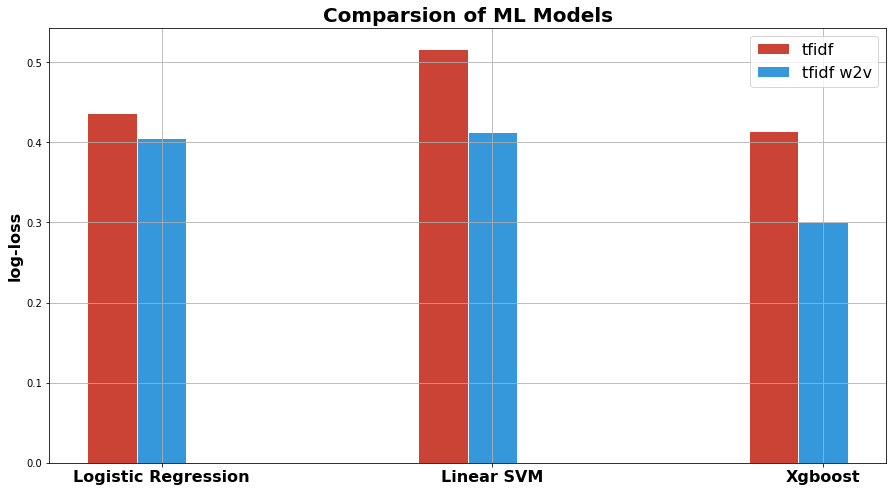

In [31]:
barWidth = 0.15
 
tfidf_logloss = [0.437, 0.517, 0.414]
tfidfw2v_logloss = [0.406, 0.413, 0.30]

# Seting position of bar on X axis
r1 = np.arange(len(tfidf_logloss))
r2 = [x + barWidth for x in r1]
 
# Making the plot
plt.figure(figsize = (15,8))
plt.bar(r1, tfidf_logloss, color='#CB4335', width=barWidth, edgecolor='white', label='tfidf')
plt.bar(r2, tfidfw2v_logloss, color='#3498DB', width=barWidth, edgecolor='white', label='tfidf w2v')

plt.xticks([r + barWidth for r in range(len(tfidf_logloss))], ['Logistic Regression', 'Linear SVM', 'Xgboost'], fontsize=16, fontweight='bold')
plt.ylabel('log-loss', fontweight='bold',fontsize = 16)
plt.title("Comparsion of ML Models", fontweight='bold', fontsize = 20)
plt.legend(fontsize = 16)
plt.grid()
plt.show()

# 8. CONCLUSION

## 8.1 Steps Followed
-  Data is loaded and some basis statistics about the data is observed.
-  If any duplicate or null datapoints present, are removed.
-  Exploaratory data analysis on question pairs is done like Distribution of data points among output classes, Number of unique questions,  Number of occurrences of each question.
-  *Feature Engineering of basic features before cleaning*: Some basic features like freq_qid1,freq_qid2,word_Common,word_share etc are extracted.
-  EDA on basic features is done.
-  Preprocessing and cleaning of questions like stemming,removal of html,stopwords removal etc is done.
-  *Feature Engineering of advanced/fuzzy features after cleaning*: Some advanced and fuzzy features are extracted.
-  EDA on advanced features like piarplot of  features, univariate analysis, TSNE Visualization(2D and 3D) is done.
-  Wordcloud representaion of duplicate and non-duplicate questions pairs.
-  Since it is a binary classification problem, log-loss is chosen as perfomance metric and a basline random model is build to define the range of log-loss.
-  Building of Machine Learning models(Logistic Regression,Linear SVM and XGBoost) using combination of basic,advanced and tfidf features.
-  Building of Machine Learning models(Logistic Regression,Linear SVM and XGBoost) using combination of basic,advanced and tfidf weighetd wor2vec features.
-  Tuning of sevel hyper-parameters of XGBoost using Randomsearch(3 fold cross validation).
-  Comparsion of models performance  wrt log-loss,binary confusion, precision and recall matrix.

## 8.2 Comparsion of ML Models

| ML Model |  <b>log-loss(tfidf)</b> | <b>log-loss(tfidf w2v)</b> |
| --- | --- | --- | 
| <b>Logistic Regression</b> | 0.437 | 0.406  |
| <b>Linear SVM</b> | 0.517 | 0.413   | 
| <b>XGBoost</b> | 0.414 | 0.3008   |

<b>XGboost performs the best using basic + nlp/advanced + tfidf w2v features with a log-loss of 0.3008</b>.